<a href="https://colab.research.google.com/github/vlamen/tue-deeplearning/blob/main/assignments/assignment_2_3/a2_skeleton.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Group Number: 38

# Student 1:

# Student 2:

# Student 3:

# Downloading Data and Preliminaries

In [1]:
import pickle
import matplotlib.pyplot as plt
import matplotlib
import numpy as np
from zipfile import ZipFile
import requests
import io
import torch
import torch.nn as nn

c:\Users\Adil\Anaconda3\lib\site-packages\pandas\compat\_optional.py:138: UserWarning: Pandas requires version '2.7.0' or newer of 'numexpr' (version '2.6.8' currently installed).
  warnings.warn(msg, UserWarning)


In [2]:
def load_zip(url):
    response = requests.get(url)
    response.raise_for_status()
    zipf = ZipFile(io.BytesIO(response.content))
    return {name: zipf.read(name) for name in zipf.namelist()}

def load_array(zipfile, fn):
    return np.load(io.BytesIO(zipfile[fn]))

In [3]:
"""
This cell loads the training, validation or test data as numpy arrays,
with the positions, initial velocities and charge data of the particles.

The position arrays are shaped as
[simulation id, time point (corresponding to t = 0, 0.5, 1 or 1.5), x/y spatial dimension, particle id].

The initial velocity arrays are shaped as
[simulation id, 1 (corresponding to t=0), x/y spatial dimension, particle id].

The charge arrays are shaped as [simulation id, particle id, 1]

"""

data = load_zip('https://surfdrive.surf.nl/files/index.php/s/OIgda2ZRG8v0eqB/download')

features = ['positions', 'velocities', 'charges']
    
positions_train, velocities_train, charges_train = (load_array(data, f'data/train/{f}.npy') for f in features)
positions_valid, velocities_valid, charges_valid = (load_array(data, f'data/valid/{f}.npy') for f in features)
positions_test, velocities_test, charges_test = (load_array(data, f'data/test/{f}.npy') for f in features)

print('Shapes of the training data:\n')
print(f'positions: {positions_train.shape}')
print(f'velocities: {velocities_train.shape}')
print(f'charges: {charges_train.shape}')

Shapes of the training data:

positions: (10000, 4, 2, 5)
velocities: (10000, 1, 2, 5)
charges: (10000, 5, 1)


In [4]:
print('An example of retrieving data from the arrays:\n\n')

sim_idx = 42
t_idx = 2  # t_idx 0, 1, 2, 3 corresponds to t=0, 0.5, 1 and 1.5 respectively
spatial_idx = (0,1)  # corresponds to both x and y dimension
particle_idx = 3  # corresponds to particle with index 3

p = positions_train[sim_idx, t_idx, spatial_idx, particle_idx]
v = velocities_train[sim_idx, 0, spatial_idx, particle_idx]  # note: this array contains only the inital velocity -> hence the 0
c = charges_train[sim_idx, particle_idx, 0] 

print(
    f'In simulation {sim_idx} of the training set, particle {particle_idx} with charge {c} had coordinates {p}.\nThe initial velocity of this particle was {v}.'
)

An example of retrieving data from the arrays:


In simulation 42 of the training set, particle 3 with charge -1.0 had coordinates [ 2.05159559 -1.46130851].
The initial velocity of this particle was [ 0.28402364 -0.24784824].


In [5]:
print(p.shape)

(2,)


In [6]:
print('Overview of no. datapoints:\n')

print(f'{len(positions_train)} train, {len(positions_valid)} validation, {len(positions_test)} test simulations')

Overview of no. datapoints:

10000 train, 2000 validation, 2000 test simulations


In [7]:
def plot_example(pos, vel):

    fig = plt.figure()
    axes = plt.gca()
    axes.set_xlim([-5., 5.])
    axes.set_ylim([-5., 5.])
    colors = ['red', 'blue', 'green', 'orange', 'brown']
    for i in range(pos.shape[-1]):
        plt.plot(pos[0, 0, i], pos[0, 1, i], 'd', color=colors[i])
        plt.plot(pos[-1, 0, i], pos[-1, 1, i], 'x', color=colors[i])
        plt.plot([pos[0, 0, i], pos[0, 0, i] + vel[0, 0, i]], [pos[0, 1, i], pos[0, 1, i] + vel[0, 1, i]], '--', color=colors[i])
    fig.set_size_inches(7, 7)
    plt.xlim(np.min(pos)-1, np.max(pos) +1)
    plt.ylim(np.min(pos)-1, np.max(pos) +1)
    plt.plot([], [], 'd', color='black', label='initial position')
    plt.plot([], [], 'x', color='black', label='final position')
    plt.plot([], [], '--', color='black', label='initial velocity \ndirection and magnitude')
    plt.legend()
    
    plt.show()
    return

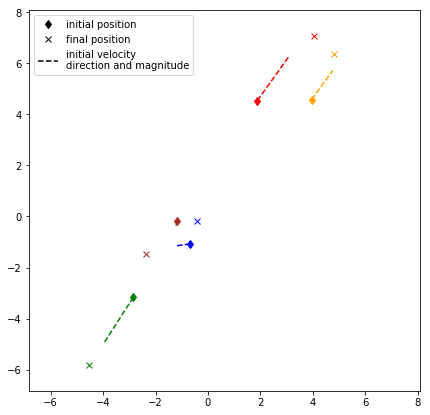

In [8]:
random_idx = np.random.randint(0, 10000)
plot_example(positions_train[random_idx], velocities_train[random_idx])

# Data Handling and Preprocessing

In [9]:
import itertools
"""
Get all lists of indices to shuffle the train set
"""
def shuffle_indices(indices):

    comb_list = []
    for x in itertools.permutations(indices):
        comb_list.append(list(x))
    return comb_list

list_indices = shuffle_indices(indices = [0, 1, 2, 3, 4])
print(len(list_indices))

120


In [10]:
"""
Shuffle the train set such that we move
each particle to a different location
such that the model is permutation invariant
"""
# too difficult to implement 

for sim in range(positions_train.shape[0]):
    for i in list_indices[:10]:
        # print(positions_train[sim])
        # print("\n")
        # print(np.transpose(positions_train[sim, :, :, i]))
        break
    break   
        

In [11]:
from torch.utils.data import Dataset, DataLoader,TensorDataset
from torch.nn.functional import normalize
class MyDataset(Dataset):
    def __init__(self, veloc, pos, charges,time_id, norm, transform=None):
        self.velocity = torch.FloatTensor(veloc)
        self.charges = torch.FloatTensor(charges)
        self.position = torch.FloatTensor(pos)
        self.time_id = time_id
        self.norm = norm
        self.transform = transform

    def __getitem__(self, index):
        x_1 = self.velocity[index] #t=0 by default
        x_2 = self.charges[index] #t=0 by default
        x_2 = x_2.reshape(-1, 1, 5) # reshape from 128, 5, 1 -> 128, 1, 5
        x_2 = x_2.repeat(1, 2, 1) # 128, 2, 5
        x_3 = self.position[index, 0].view(1,2,5) # input pos of t=0
        reshaped_array = torch.cat([x_1, x_2, x_3], dim=1)
        y = self.position[index, self.time_id].view(1,2,5) # output pos of t=time_id

        if self.norm is not False:
            reshaped_array = normalize(reshaped_array)
            y = normalize(y)
        
        if self.transform is not None:
            reshaped_array = self.transform(reshaped_array)
            y = self.transform(y)

        return reshaped_array, y

    def __len__(self):
        return len(self.charges)

# Model Implementation

In [12]:
# Simple NN network for value prediction
import numpy as np
import torch
from torch import nn
import torch.nn.functional as F
import torch.optim as optim
class SimpleModel(nn.Module):
    def __init__(self, input_dim):
        super(SimpleModel, self).__init__()
        self.layer1 = nn.Linear(input_dim, 32)
        self.layer2 = nn.Linear(32, 64)
        self.layer3 = nn.Linear(64, 64)
        self.layer4 = nn.Linear(64, 10)
        # self.layer5 = nn.Linear(32, 10)
        self.norm1 = nn.BatchNorm1d(32)
        self.norm2 = nn.BatchNorm1d(64)
        self.norm3 = nn.BatchNorm1d(10)
        self.drop = nn.Dropout(0.2)
        
        
    def forward(self, x):
        x = self.norm1(F.relu(self.layer1(x)))
        x = self.drop(x)
        x = self.norm2(F.relu(self.layer2(x)))
        x = self.drop(x)
        x = self.norm2(F.relu(self.layer3(x)))
        x = self.drop(x)
        x = self.norm3(F.relu(self.layer4(x)))
        # x = F.relu(self.layer4(x))
        # x = F.relu(self.layer5(x))
        # x = self.drop(x)
        return x

# Model Training

In [13]:
# saving and loading checkpoint mechanisms 
# modules adapted from https://github.com/ttchengab/One_Shot_Pytorch/blob/master/network.ipynb

def save_checkpoint(save_path, model, optimizer, val_loss):
  """
  Utility function for saving the model 

  Input
    --save_path: path to save the model
    --model: model to be saved
    --optimizer: optimizer to be saved
    --val_loss: lowest validation loss so far

  Output
    Saved model as pt file
  """
  if save_path==None:
      return
  save_path = save_path 
  state_dict = {'model_state_dict': model.state_dict(),
                'optimizer_state_dict': optimizer.state_dict(),
                'val_loss': val_loss}

  torch.save(state_dict, save_path)
  print(f'Model saved to ==> {save_path}')


def load_checkpoint(model, optimizer):
  """
  Utility function to load a saved model
  Input
    --model: model object to load the weights into
    --optimizer: optimizer object
    
  Output:
    Validation loss
  """
  save_path = f'SiameseNetwork.pt'
  state_dict = torch.load(save_path)
  model.load_state_dict(state_dict['model_state_dict'])
  optimizer.load_state_dict(state_dict['optimizer_state_dict'])
  val_loss = state_dict['val_loss']
  print(f'Model loaded from <== {save_path}')
  
  return val_loss

In [14]:
# NN MODEL
from tqdm import tqdm
def train(model, train_loader, val_loader, n_epochs, optimizer, criterion, save_name):
    train_losses = []
    val_losses = []
    best_val_loss = float("Inf")
    for _ in range(1, n_epochs + 1):
        model.train()

        for x, y in tqdm(train_loader):
            y = y.view(y.shape[0], 10)
            x = x.view(x.shape[0], 30)
            batch_loss = 0.0
            optimizer.zero_grad()
            outputs = model(x)
            loss = criterion(outputs, y)
            batch_loss += loss.item()
            loss.backward()
            optimizer.step()
            
        avg_train_loss = batch_loss / len(train_loader) # batch size
        train_losses.append(avg_train_loss)

        with torch.no_grad():
            model.eval()
            for x, y in val_loader:
                y = y.view(y.shape[0], 10)
                x = x.view(x.shape[0], 30)
                val_batch_loss = 0.0
                outputs = model(x)
                # output_val.append(outputs)
                loss = criterion(outputs, y)
                val_batch_loss += loss.item()

        avg_val_loss = val_batch_loss / len(val_loader) # batch size
        val_losses.append(avg_val_loss)

        if avg_val_loss < best_val_loss:
            best_val_loss = avg_val_loss
            save_checkpoint(save_name, model, optimizer, best_val_loss)

    return train_losses, val_losses

In [16]:
learning_rate = 1e-3
weight_decay = 1e-6

model_10000_1 = SimpleModel(input_dim=30)
model_10000_2 = SimpleModel(input_dim=30)
model_10000_3 = SimpleModel(input_dim=30)
model_1000_1 = SimpleModel(input_dim=30)
model_1000_2 = SimpleModel(input_dim=30)
model_1000_3 = SimpleModel(input_dim=30)
model_100_1 = SimpleModel(input_dim=30)
model_100_2 = SimpleModel(input_dim=30)
model_100_3 = SimpleModel(input_dim=30)

optimizer_10000_1 = optim.Adam(model_10000_1.parameters(), lr=learning_rate, weight_decay=weight_decay)
optimizer_10000_2 = optim.Adam(model_10000_2.parameters(), lr=learning_rate, weight_decay=weight_decay)
optimizer_10000_3 = optim.Adam(model_10000_3.parameters(), lr=learning_rate, weight_decay=weight_decay)
optimizer_1000_1  = optim.Adam(model_1000_1.parameters(), lr=learning_rate, weight_decay=weight_decay)
optimizer_1000_2  = optim.Adam(model_1000_2.parameters(), lr=learning_rate, weight_decay=weight_decay)
optimizer_1000_3  = optim.Adam(model_1000_3.parameters(), lr=learning_rate, weight_decay=weight_decay)
optimizer_100_1  =  optim.Adam(model_100_1.parameters(), lr=learning_rate, weight_decay=weight_decay)
optimizer_100_2 =   optim.Adam(model_100_2.parameters(), lr=learning_rate, weight_decay=weight_decay)
optimizer_100_3 =   optim.Adam(model_100_3.parameters(), lr=learning_rate, weight_decay=weight_decay)



In [ ]:
def train_loop(samples, timeids, models, optimizers, criterion):
    count = 0
    for sample in samples:
        for timeid in timeids:
            train_dataset =MyDataset(velocities_train[:sample], positions_train[:sample], charges_train[:sample], time_id = timeid, norm = True, transform=None) 
            val_dataset = MyDataset(velocities_valid, positions_valid, charges_valid, time_id = timeid, norm = True, transform=None) 

            train_loader = torch.utils.data.DataLoader(train_dataset, batch_size=128) 
            val_loader = torch.utils.data.DataLoader(val_dataset, batch_size=128) 
            trainloss, valloss = train(model= models[count], train_loader= train_loader, val_loader=val_loader, n_epochs=10, optimizer= optimizers[count], criterion=criterion, save_name='models\\NN' + '_' + str(sample) + '_' + str(timeid) + '.pt')
            plt.figure()
            plt.xlabel('epoch')
            plt.ylabel('loss')
            plt.plot(trainloss, label='Train Loss')
            plt.plot(valloss, label="Validation Loss")
            plt.legend(bbox_to_anchor=(1.05, 1.0), loc='upper left')
            plt.savefig("images\\NN" + '_' + str(sample) + '_' + str(timeid) + ".png")
            plt.show
            plt.close()
            print(count)
            count +=1
            

samples = [100, 1000, 10000]
timeids = [1, 2, 3]
models = [model_100_1, model_100_2, model_100_3, model_1000_1, model_1000_2, model_1000_3, model_10000_1, model_10000_2, model_10000_3]
optimizers = [optimizer_100_1, optimizer_100_2, optimizer_100_3, optimizer_1000_1, optimizer_1000_2, optimizer_1000_3, optimizer_10000_1, optimizer_10000_2, optimizer_10000_3]
learning_rate = 1e-3
weight_decay = 1e-6
loss_fn = nn.MSELoss(reduction="mean") # can do MSE/MAE depends on outliers
train_loop(samples, timeids, models, optimizers, loss_fn)

## Prediction + label

In [58]:
# GET OUR PREDICTIONS AND LABELS
from varname import nameof

from tqdm import tqdm
def test(models, testloaders):
    output_dict = dict()
    with torch.no_grad():
        models_1 = models[::3] # models for time horizon 0.5 (timeid = 1)
        models_2 = models[1::3] # models for time horizon 1 (timeid = 2)
        models_3 = models[2::3] # models for time horizon 1.5 (timeid = 3)
        for index, model in enumerate(models_1):
            output_test = [] 
            labels = []
            model.eval()
            count = 0
            for x, y in testloaders[0]:
                y = y.view(y.shape[0], 10)
                x = x.view(x.shape[0], 30)
                outputs = model(x)
                output_test.append(outputs)
                labels.append(y)
                count += 1
            output_dict['model_100_' + str(index+1) + '_output'] = output_test
            output_dict['model_100_' + str(index+1) + '_labels'] = labels
        for index, model in enumerate(models_2):
            model.eval()
            for x, y in testloaders[1]:
                y = y.view(y.shape[0], 10)
                x = x.view(x.shape[0], 30)
                outputs = model(x)
                output_test.append(outputs)
                labels.append(y)
            output_dict['model_1000_' + str(index+1) + '_output'] = output_test
            output_dict['model_1000_' + str(index+1) + '_labels'] = labels
        for index, model in enumerate(models_3):
            model.eval()
            for x, y in testloaders[2]:
                y = y.view(y.shape[0], 10)
                x = x.view(x.shape[0], 30)
                outputs = model(x)
                output_test.append(outputs)
                labels.append(y)
            output_dict['model_10000_' + str(index+1) + '_output'] = output_test
            output_dict['model_10000_' + str(index+1) + '_labels'] = labels
    return output_dict

In [59]:
test_dataset_1 = MyDataset(velocities_test, positions_test, charges_test, time_id = 1, norm = True, transform=None)
test_dataset_2 = MyDataset(velocities_test, positions_test, charges_test, time_id = 2, norm = True, transform=None)
test_dataset_3 = MyDataset(velocities_test, positions_test, charges_test, time_id = 3, norm = True, transform=None)
test_loader_1 = torch.utils.data.DataLoader(test_dataset_1, batch_size=128) # len(test_dataset) = 2000
test_loader_2 = torch.utils.data.DataLoader(test_dataset_2, batch_size=128) # len(test_dataset) = 2000
test_loader_3 = torch.utils.data.DataLoader(test_dataset_3, batch_size=128) # len(test_dataset) = 2000

testloaders = [test_loader_1, test_loader_2, test_loader_3]
test_dict = test(models, testloaders)
test_dict.keys()

# Right now we return the prediction and the labels for each model

dict_keys(['model_100_1_output', 'model_100_1_labels', 'model_100_2_output', 'model_100_2_labels', 'model_100_3_output', 'model_100_3_labels', 'model_1000_1_output', 'model_1000_1_labels', 'model_1000_2_output', 'model_1000_2_labels', 'model_1000_3_output', 'model_1000_3_labels', 'model_10000_1_output', 'model_10000_1_labels', 'model_10000_2_output', 'model_10000_2_labels', 'model_10000_3_output', 'model_10000_3_labels'])

In [64]:
# append predictions and labels to list
def split_output(test_output, labels):
    test_x = []
    test_y = []
    act_x = []
    act_y = []
    for batch in test_output:
        arr = batch.numpy()
        for sim in range(arr.shape[0]):
            y = arr[sim][1::2] # take every even index
            x = arr[sim][::2] # take every even index
        
            test_x.extend(x)
            test_y.extend(y)
    
    for lab_batch in labels:
        arr_lab = lab_batch.numpy()
        for sim in range(arr_lab.shape[0]):
            y_lab = arr_lab[sim][1::2] # take every even index
            x_lab = arr_lab[sim][::2] # take every even index
        
            act_x.extend(x_lab)
            act_y.extend(y_lab)
    
    return test_x, test_y, act_x, act_y

x_pred, y_pred, x_act, y_act = split_output(test_dict['model_100_1_output'], test_dict['model_100_1_labels'])

In [ ]:
# fig = plt.figure()
# plt.xlabel('simulations')
# plt.ylabel('position at t=0.5')
# fig.set_size_inches(10, 7)
# plt.plot(x_pred[::50], label='NN x prediction') 
# plt.plot(y_pred[::50], label='NN y predication') 
# plt.plot(baseline_pred_x[::50], label='Formula x prediction') # not normalized
# plt.plot(baseline_pred_y[::50], label='Formula y prediction') # not normalized
# plt.plot(x_act[::50], label='x actual ')
# plt.plot(y_act[::50], label='y actual')
# plt.legend(bbox_to_anchor=(1.05, 1.0), loc='upper left')
# plt.show()

# PROBLEM: DATA IS NORMALIZED BUT BASELINE PREDICTIONS ARENT

## Baseline predictions

In [ ]:
# Formala prediction for each t
def baseline_prediction(t):
    baseline_pred_x = []
    baseline_pred_y = []
    for sim in range(2000): # should be 2000
        for ptxd in range(5):
            #x_t = x_0 + v_0 * t for (x, y)
            x_pos, y_pos = (positions_test[sim, 0, 0, ptxd]) + (velocities_test[sim, 0, 0, ptxd]*t), positions_test[sim, 0, 1, ptxd] + (velocities_test[sim, 0, 1, ptxd]*t)
            baseline_pred_x.append(x_pos)
            baseline_pred_y.append(y_pos)
    return baseline_pred_x, baseline_pred_y
# charges_test
baseline_pred_x, baseline_pred_y = baseline_prediction(t=0.5)

# Evaluation

In [ ]:
# subtract outputs from labels and avg loss
# subtract baseline from labels and avg loss
# compare both

## RNN TEST

In [ ]:
# LSTmodel RNN
#####
#https://towardsdatascience.com/building-rnn-lstm-and-gru-for-time-series-using-pytorch-a46e5b094e7b
####
class LSTMModel(nn.Module):
    # input dim are the features which should be only 1 right t=0?
    # or is it 5 because 5 particles?
    def __init__(self, input_dim = 30 , hidden_dim = 256, layer_dim = 2, output_dim = 10, dropout_prob = 0.2):
        super(LSTMModel, self).__init__()

        # Defining the number of layers and the nodes in each layer
        self.hidden_dim = hidden_dim
        self.layer_dim = layer_dim

        # LSTM layers
        self.lstm = nn.LSTM(
            input_dim, hidden_dim, layer_dim, batch_first=True, dropout=dropout_prob
        )

        # Fully connected layer
        self.fc = nn.Linear(hidden_dim, output_dim)

    def forward(self, x):
        # Initializing hidden state for first input with zeros
        h0 = torch.zeros(self.layer_dim, x.size(0), self.hidden_dim).requires_grad_()

        # Initializing cell state for first input with zeros
        c0 = torch.zeros(self.layer_dim, x.size(0), self.hidden_dim).requires_grad_()

        # We need to detach as we are doing truncated backpropagation through time (BPTT)
        # If we don't, we'll backprop all the way to the start even after going through another batch
        # Forward propagation by passing in the input, hidden state, and cell state into the model
        out, (hn, cn) = self.lstm(x, (h0.detach(), c0.detach()))

        # Reshaping the outputs in the shape of (batch_size, seq_length, hidden_size)
        # so that it can fit into the fully connected layer
        out = out[:, -1, :]

        # Convert the final state to our desired output shape (batch_size, output_dim)
        out = self.fc(out)

        return out

In [ ]:
# RNN MODEL
from tqdm import tqdm
def trainRNN(model, train_loader, n_epochs, optimizer, criterion):
    train_losses = []
    val_losses = []
    for _ in range(1, n_epochs + 1):
        output_val = [] #get output of last epoch in val
        model.train()

        for x, y in tqdm(train_loader):
            y = y.view(y.shape[0], 10)
            x = x.view(x.shape[0], 1, 30)
            batch_loss = 0.0
            optimizer.zero_grad()
            outputs = model(x)
            outputs = outputs.squeeze()
            loss = criterion(outputs, y)
            batch_loss += loss.item()
            loss.backward()
            optimizer.step()
            
        avg_train_loss = batch_loss / len(train_loader) # batch size
        train_losses.append(avg_train_loss)

        with torch.no_grad():
            model.eval()
            for x, y in val_loader:
                y = y.view(y.shape[0], 10)
                x = x.view(x.shape[0], 1, 30)  
                val_batch_loss = 0.0
                outputs = model(x)
                output_val.append(outputs)
                loss = criterion(outputs, y)
                val_batch_loss += loss.item()

        avg_val_loss = val_batch_loss / len(val_loader) # batch size
        val_losses.append(avg_val_loss)

    return train_losses, val_losses, output_val

In [ ]:

loss_fn = nn.MSELoss(reduction="mean") # can do MSE/MAE depends on outliers
RNN_network = LSTMModel()
optimizer = optim.Adam(RNN_network.parameters(), lr=learning_rate, weight_decay=weight_decay)
trainloss, valloss, output_val = trainRNN(model= RNN_network, train_loader=train_loader, n_epochs=10, optimizer= optimizer, criterion=loss_fn)


In [ ]:
plt.xlabel('epoch')
plt.ylabel('loss')
plt.plot(trainloss, label='Train Loss')
plt.plot(valloss, label="Validation Loss")
plt.legend(bbox_to_anchor=(1.05, 1.0), loc='upper left')
plt.show()